# MATH 441 Project 3: Energy Production Optimization

**Environmental Impact Minimization with Mixed Integer Programming**

In [2]:
%pip install cvxpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.colors as mcolors

## 1. Problem Statement

We need to determine the optimal mix of energy production facilities to minimize environmental impact while meeting energy demands. Different energy sources (coal, natural gas, nuclear, etc.) have varying environmental impacts, production capacities, and costs. The energy demand and production efficiency vary by time of day and season.

## 2. Mathematical Formulation

### Sets
- $i \in I$: Types of energy sources (coal, natural gas, nuclear, hydro, solar, wind, geothermal)
- $p \in P$: Time periods (morning, noon, evening, night)
- $s \in S$: Seasons (winter, spring, summer, fall)

### Parameters
- $co2_i$: Hourly CO₂ emissions (units/h) per facility of energy type $i$
- $air_i$:  Hourly air pollution (units/h) per facility of energy type $i$
- $water_i$: Hourly water pollution (units/h) per facility of energy type $i$
- $e_i$: Hourly environmental impacts per facility of energy type $i$, a integration of CO₂, air and water pollution \
$$ e_i = (w_{co2} \cdot co2_i + w_{air} \cdot air_i + w_{water} \cdot water_i) $$
- $prod_i$: Hourly base production capacity (MW/h) per facility of energy type $i$
- $cc_i$: Construction cost (million dollars) per facility of energy type $i$
- $pc_i$: production cost (thousand dollars) per hour per facility of energy type $i$
- $h_{ips}$: Working hours for energy source $i$ during period $p$ in season $s$
- $B$: Total available budget for construction (million dollars)
- $D_{ps}$: Hourly electricity demand (MW) during period $p$ in season $s$
- $w_{co2}$, $w_{air}$, $w_{water}$: Weights for different environmental impacts
- $\alpha$ weight for environmental factor
- $\beta$ weight for economic factor
- $r$: Maximum allowable ratio for a single energy type in total production
  
### Decision Variables
- $x_i$: Number of facilities to build of energy type $i$ (integer)

### Objective Function
Minimize the weighted total environmental impact:
$$\min \sum_{i \in I} (\alpha \dot e_i + \beta pc_i) \cdot x_i \cdot \sum_{p \in P}\sum_{s \in S} h_{ips}$$


### Constraints

#### Budget Constraint
$$\sum_{i \in I} cc_i \cdot x_i \leq B$$

#### Demand Constraints
For each time period and season, production must meet demand:
$$\sum_{i \in I} prod_i \cdot h_{ips} \cdot x_i \geq D_{ps} \quad \forall p \in P, s \in S$$

#### Non-negativity and Integer Constraints
$$x_i \geq 0 \text{ and integer} \quad \forall i \in I$$

#### Factor Diversity Constraint
The number of each type of factory should be less then $r$ of the total number of factory
$$ x_i \leq r \cdot \sum_{i \in I} x$$

## 3. Data Loading and Preprocessing

In [3]:
data = pd.read_csv('data_project3_final.CSV')
data.head()

,Energy Source,Production (MW/h),CO? Emissions (unit/h),Air Pollution (unit/h),Water Pollution (unit/h),Cost to Produce ($/h),Cost to build(million $),Cost to Maintain ($/h),Cost to Transport ($/M),Winter Morning,...,Spring Evening,Spring Night,Summer Morning,Summer Noon,Summer Evening,Summer Night,Fall Morning,Fall Noon,Fall Evening,Fall Night
0,Coal,1100,18.0,15.2,12.5,65,1000,30,10,6,...,6,6,6,6,6,6,6,6,6,6
1,Natural Gas,1000,9.0,7.5,5.8,50,1900,20,8,3,...,5,3,4,5,6,4,3,5,5,3
2,Nuclear,1050,0.5,0.5,8.0,25,10000,50,5,6,...,6,6,6,6,6,6,6,6,6,6
3,Hydro,755,0.2,1.8,4.5,20,3000,20,2,2,...,6,5,5,6,6,5,3,5,6,5
4,Solar,700,0.1,0.8,0.1,40,2500,10,2,2,...,3,0,4,6,4,0,3,5,3,0


In [ ]:
energy_sources = data['Energy Source'].values
production = data['Production (MW/h)'].values
co2_emissions = data['CO? Emissions (unit/h)'].values
air_pollution = data['Air Pollution (unit/h)'].values
water_pollution = data['Water Pollution (unit/h)'].values
prod_cost = data['Cost to Produce ($/h)'].values
build_cost = data['Cost to build(million $)'].values


seasons = ['Winter', 'Spring', 'Summer', 'Fall']
periods = ['Morning', 'Noon', 'Evening', 'Night']
efficiency_columns = [f"{season} {period}" for season in seasons for period in periods]

# Create matrix for working hours for given periods and given seasons
efficiency_matrix = data[efficiency_columns].values


efficiency_3d = np.zeros((len(energy_sources), len(periods), len(seasons)))
for i, source in enumerate(energy_sources):
    for p, period in enumerate(periods):
        for s, season in enumerate(seasons):
            col_name = f"{season} {period}"
            col_index = efficiency_columns.index(col_name)
            efficiency_3d[i, p, s] = efficiency_matrix[i, col_index]

Loaded data for 7 energy sources across 4 periods and 4 seasons.
[[[6. 6. 6. 6.]
  [6. 6. 6. 6.]
  [6. 6. 6. 6.]
  [6. 6. 6. 6.]]

 [[3. 3. 4. 3.]
  [5. 5. 5. 5.]
  [4. 5. 6. 5.]
  [6. 3. 4. 3.]]

 [[6. 6. 6. 6.]
  [6. 6. 6. 6.]
  [6. 6. 6. 6.]
  [6. 6. 6. 6.]]

 [[2. 3. 5. 3.]
  [2. 5. 6. 5.]
  [3. 6. 6. 6.]
  [3. 5. 5. 5.]]

 [[2. 3. 4. 3.]
  [3. 5. 6. 5.]
  [2. 3. 4. 3.]
  [0. 0. 0. 0.]]

 [[5. 4. 3. 4.]
  [3. 6. 2. 3.]
  [6. 5. 4. 5.]
  [6. 5. 5. 5.]]

 [[6. 6. 6. 6.]
  [6. 6. 6. 6.]
  [6. 6. 6. 6.]
  [6. 6. 6. 6.]]]


In [20]:
working_hours = np.sum(efficiency_3d, axis=(1, 2))
print(working_hours)

[96. 69. 96. 70. 43. 71. 96.]


## 4. Visualization of Energy Source Characteristics

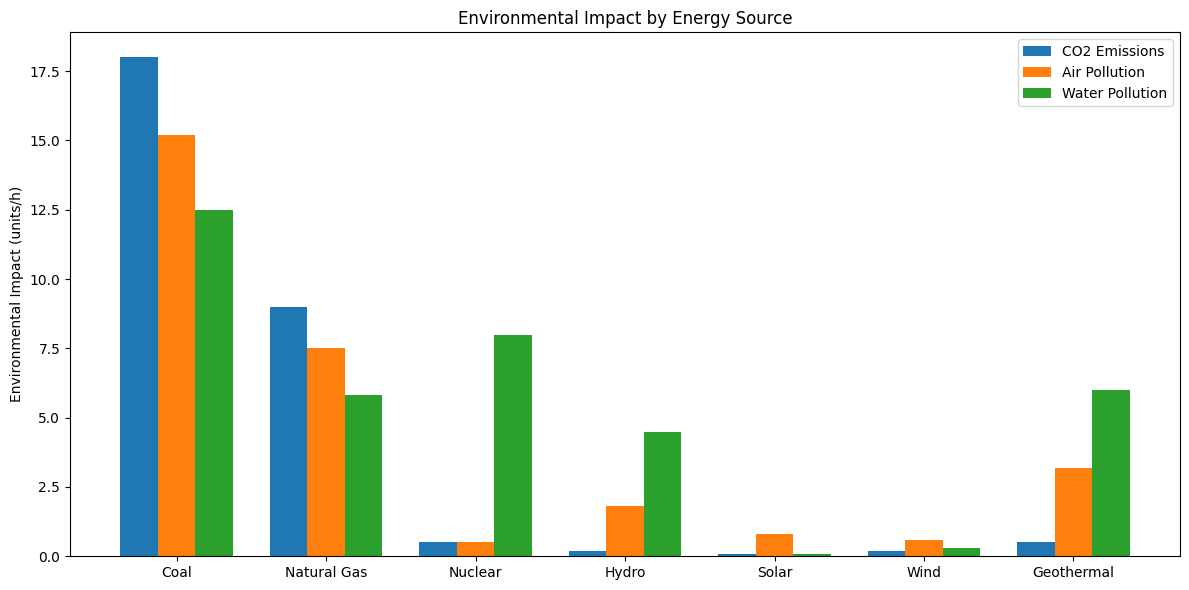

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(energy_sources))

ax.bar(x - 0.25, co2_emissions, 0.25, label='CO2 Emissions')
ax.bar(x, air_pollution, 0.25, label='Air Pollution')
ax.bar(x + 0.25, water_pollution, 0.25, label='Water Pollution')

ax.set_xticks(x)
ax.set_xticklabels(energy_sources)
ax.legend()
ax.set_ylabel('Environmental Impact (units/h)')
ax.set_title('Environmental pollution by Energy Source')
plt.tight_layout()
plt.show()

<ipython-input-25-6a16481b30d4>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


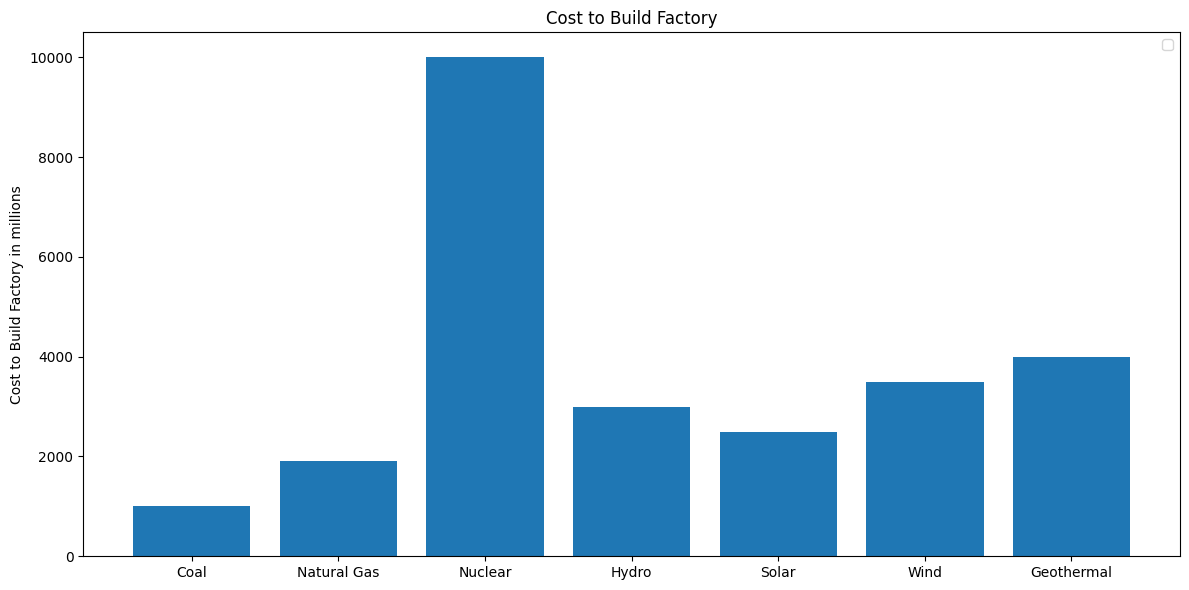

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(energy_sources))

ax.bar(x, build_cost)


ax.set_xticks(x)
ax.set_xticklabels(energy_sources)
ax.legend()
ax.set_ylabel('Cost to Build Factory in millions')
ax.set_title('Cost to Build Factory')
plt.tight_layout()
plt.show()

## 5. Heatmap of Operation Hour

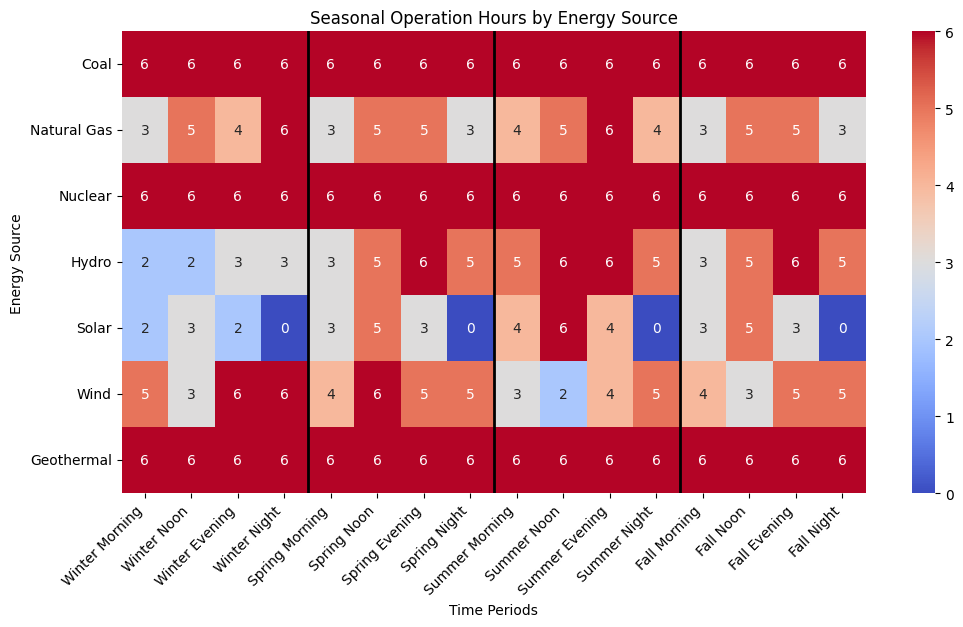

In [32]:
season_columns = [
    "Winter Morning", "Winter Noon", "Winter Evening", "Winter Night",
    "Spring Morning", "Spring Noon", "Spring Evening", "Spring Night",
    "Summer Morning", "Summer Noon", "Summer Evening", "Summer Night",
    "Fall Morning", "Fall Noon", "Fall Evening", "Fall Night"
]

season_data = data.set_index("Energy Source")[season_columns]

plt.figure(figsize=(12, 6))
ax = sns.heatmap(season_data, cmap="coolwarm", annot=True)

for i in range(4, len(season_columns), 4):
    ax.axvline(i, color='black', lw=2)

plt.title("Seasonal Operation Hours by Energy Source")
plt.xlabel("Time Periods")
plt.ylabel("Energy Source")
plt.xticks(rotation=45,ha='right')
plt.show()

## 6. Model Parameters Setup

In [ ]:

construct_budget = 100000  # in million $
base_demand = 70000  # Base demand in MW
demand = np.zeros((len(periods), len(seasons)))

# Seasonal variations
season_factors = {'Winter': 1.3, 'Spring': 0.8, 'Summer': 1.2, 'Fall': 0.9}
# Period variations
period_factors = {'Morning': 1.1, 'Noon': 1.3, 'Evening': 1.4, 'Night': 0.7}

for p, period in enumerate(periods):
    for s, season in enumerate(seasons):
        demand[p, s] = base_demand * season_factors[season] * period_factors[period]

# Hours in each period-season combination
# Assume: 90 days per season, periods are: morning (6h), noon (6h), evening (6h), night (6h)
hours_per_period = 6
days_per_season = 90
hours = np.full((len(periods), len(seasons)), hours_per_period * days_per_season)


np.float64(58799.99999999999)

In [69]:
demand

array([[100100.,  61600.,  92400.,  69300.],
       [118300.,  72800., 109200.,  81900.],
       [127400.,  78400., 141120.,  88200.],
       [ 63700.,  39200., 141120.,  44100.]])

## 7. Optimization Model

In [70]:
n = len(energy_sources)

# Decision variables: number of facilities for each energy source built
x = cp.Variable(n, integer=True)

# Weight for environmental factor
W1 = 0.5
# weight for economic factor
W2 = 0.5

# Environmental impact weights
w_co2 = 0.1
w_air = 0.3
w_water = 0.6
env_impact = w_co2 * co2_emissions + w_air * air_pollution + w_water * water_pollution

# Objective: Minimize weighted environmental impact
objective = cp.Minimize((cp.sum(cp.multiply(env_impact * working_hours, x)) * W1 + cp.sum(cp.multiply(prod_cost * working_hours, x))  * W2))

constraints = []

# Budget constraint
constraints.append(cp.sum(cp.multiply(build_cost, x)) <= construct_budget)

# Demand constraints for each period and each season
for p in range(len(periods)):
    for s in range(len(seasons)):
        # Calculate the actual production for each ennrgy source in this period-season
        effective_prod = np.array([production[i] * efficiency_3d[i, p, s] for i in range(n)])
        constraints.append(cp.sum(cp.multiply(effective_prod, x)) >= demand[p, s])

# Factor diversity constraints
proportion = 0.25
for i in range(n):
    constraints.append(x[i] <= proportion*cp.sum(x))

constraints.append(x >= 0)


prob = cp.Problem(objective, constraints)
prob.solve()

np.float64(61863.405)

## 8. Results Analysis

In [71]:
print(f"Problem status: {prob.status}")

Problem status: optimal


In [72]:
optimal_facilities = np.round(x.value).astype(int)

results = pd.DataFrame({
    'Energy Source': energy_sources,
    'Number of Facilities': optimal_facilities,
    'Production Capacity (MW/h)': production * optimal_facilities,
    'CO2 Emissions (unit/h)': co2_emissions * optimal_facilities,
    'Air Pollution (unit/h)': air_pollution * optimal_facilities,
    'Water Pollution (unit/h)': water_pollution * optimal_facilities,
    'Construction Cost (million $)': build_cost * optimal_facilities
})
print("\n")
print("Optimal Energy Mix:")
print(results[['Energy Source', 'Number of Facilities']])
print("\n")

print(f"Total Construction Cost in million")
print(results['Construction Cost (million $)'].sum())
print("Available Budget in million:")
print(construct_budget)



total_hours = np.sum(hours)
total_co2 = np.sum(results['CO2 Emissions (unit/h)']) * total_hours
total_air = np.sum(results['Air Pollution (unit/h)']) * total_hours
total_water = np.sum(results['Water Pollution (unit/h)']) * total_hours
print("\n")
print("Annual Environmental Impact:")

print("CO2 Emissions:")
print(total_co2)
print("Air Pollution: ")
print(total_air)
print("Water Pollution: ")
print(total_water)



Optimal Energy Mix:
  Energy Source  Number of Facilities
0          Coal                     8
1   Natural Gas                     8
2       Nuclear                     4
3         Hydro                     8
4         Solar                     3
5          Wind                     1
6    Geothermal                     0


Total Construction Cost in million
98200
Available Budget in million:
100000


Annual Environmental Impact:
CO2 Emissions:
1901664.0
Air Pollution: 
1736640.0
Water Pollution: 
1857600.0000000002
